##########################################
**CAUTION**
file er modhe left hand dile direct.................

In [ ]:
!pip install opendatasets

In [1]:
from google.colab import files
files.upload()  # Upload the kaggle.json file here


{}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!pip install kaggle


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
zip_path = '/content/drive/MyDrive/Sadi/DATA/archive.zip'


In [6]:
!unzip -q "/content/drive/MyDrive/Sadi/DATA/archive.zip" -d "/content/drive/MyDrive/Sadi/DATA/2_D data"




In [3]:
import tensorflow as tf

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Sadi/DATA/2_D data',  # adjust if necessary
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
)

# Preview a batch
for images, labels in train_dataset.take(1):
    print(images.shape, labels.shape)


Found 12581 files belonging to 2 classes.
(32, 224, 224, 3) (32, 2)


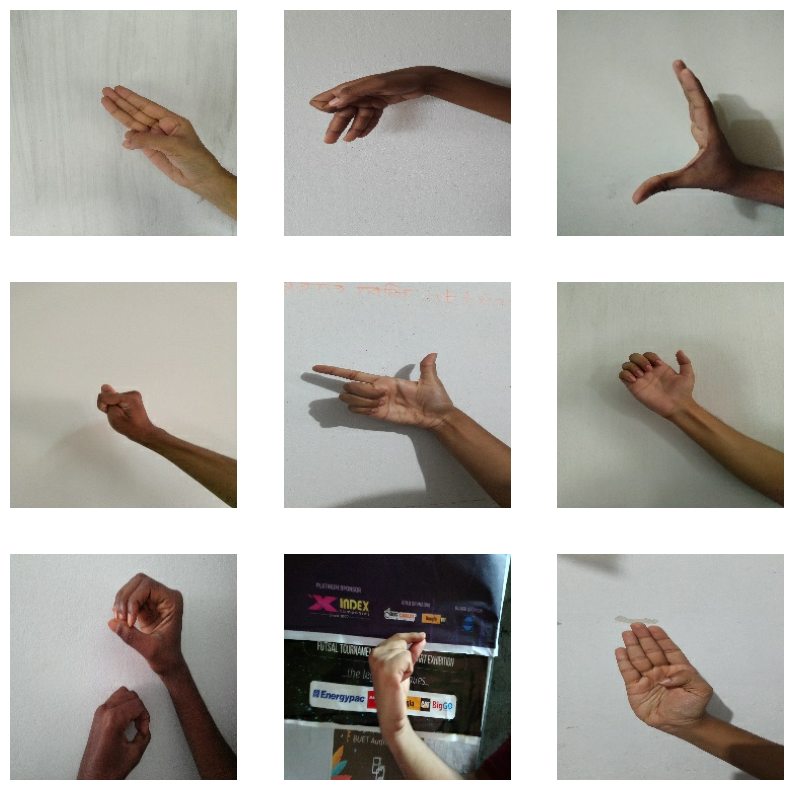

In [7]:
import matplotlib.pyplot as plt

# Take one batch from your dataset
for images, labels in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show 9 images
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()



In [8]:
# ============================================
# PART 1: IMPORTS AND CUSTOM LAYERS
# ============================================

import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import math

print("TensorFlow version:", tf.__version__)

class PatchExtraction(layers.Layer):
    """Extract patches from feature maps for Vision Transformer processing"""
    def __init__(self, patch_size=2, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEmbedding(layers.Layer):
    """Patch embedding layer for Vision Transformer"""
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

TensorFlow version: 2.19.0


In [9]:
# ============================================
# PART 2: MULTI-HEAD ATTENTION AND TRANSFORMER BLOCK
# ============================================

class MultiHeadAttention(layers.Layer):
    """Multi-head attention mechanism"""
    def __init__(self, embed_dim, num_heads=8, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

class TransformerBlock(layers.Layer):
    """Transformer block with multi-head attention and feed-forward network"""
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = MultiHeadAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [10]:
# ============================================
# PART 3: HYBRID MODEL CREATION FUNCTION
# ============================================

def create_mobilenet_vit_hybrid(input_shape, num_classes, patch_size=2,
                               projection_dim=256, num_heads=8,
                               transformer_layers=4, ff_dim=512):
    """
    Create a hybrid model combining MobileNetV2 feature extraction with Vision Transformer

    Args:
        input_shape: Input image shape (height, width, channels)
        num_classes: Number of output classes
        patch_size: Size of patches for ViT processing
        projection_dim: Dimension for patch embeddings
        num_heads: Number of attention heads
        transformer_layers: Number of transformer blocks
        ff_dim: Feed-forward dimension in transformer blocks
    """
    inputs = layers.Input(shape=input_shape)

    # MobileNetV2 backbone (remove top layers)
    mobilenet = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )

    # Make MobileNet layers non-trainable initially (for transfer learning)
    mobilenet.trainable = False

    # Extract features from MobileNet (7x7x1280 for 224x224 input)
    mobilenet_features = mobilenet(inputs)

    # Reduce channel dimensions for efficiency
    feature_reducer = layers.Conv2D(
        filters=projection_dim//4,
        kernel_size=1,
        activation='relu',
        name='feature_reducer'
    )(mobilenet_features)

    # Extract patches from reduced features
    patches = PatchExtraction(patch_size=patch_size)(feature_reducer)

    # Calculate number of patches
    feature_map_size = input_shape[0] // 32  # MobileNet reduces by factor of 32
    num_patches = (feature_map_size // patch_size) ** 2

    print(f"Feature map size: {feature_map_size}x{feature_map_size}")
    print(f"Number of patches: {num_patches}")
    print(f"Patch dimension: {projection_dim//4 * patch_size * patch_size}")

    # Create patch embeddings
    encoded_patches = PatchEmbedding(num_patches, projection_dim)(patches)

    # Apply transformer blocks
    for i in range(transformer_layers):
        encoded_patches = TransformerBlock(
            projection_dim,
            num_heads,
            ff_dim,
            name=f'transformer_block_{i}'
        )(encoded_patches)

    # Global average pooling over patch dimension
    representation = layers.GlobalAveragePooling1D()(encoded_patches)

    # Add global features from MobileNet
    global_features = layers.GlobalAveragePooling2D()(mobilenet_features)
    global_features = layers.Dense(projection_dim//2, activation='relu')(global_features)

    # Combine transformer and global features
    combined_features = layers.Concatenate()([representation, global_features])

    # Classification head
    features = layers.Dropout(0.3)(combined_features)
    features = layers.Dense(512, activation='relu')(features)
    features = layers.Dropout(0.2)(features)
    outputs = layers.Dense(num_classes, activation='softmax')(features)

    model = Model(inputs, outputs)
    return model

print("Hybrid model creation function defined successfully!")

Hybrid model creation function defined successfully!


In [17]:
# ============================================
# PART 4: DATA LOADING AND PREPROCESSING
# ============================================

# Load dataset
print("Loading dataset...")
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/Sadi/DATA/2_D data',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
)

num_classes = len(full_dataset.class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {full_dataset.class_names}")

# Calculate dataset sizes and create splits
dataset_size = full_dataset.cardinality().numpy()
val_size = int(0.2 * dataset_size)
train_size = dataset_size - val_size

print(f"Total batches: {dataset_size}")
print(f"Training batches: {train_size}")
print(f"Validation batches: {val_size}")

train_dataset = full_dataset.take(train_size)
val_dataset = full_dataset.skip(train_size)

# Optimize validation dataset
val_dataset = val_dataset.unbatch().batch(32, drop_remainder=False)

# Data augmentation for training (optional)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Apply augmentation only to training data
def augment_data(image, label):
    return data_augmentation(image, training=True), label

# Uncomment the next line if you want to use data augmentation
# train_dataset = train_dataset.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print("Dataset loading and preprocessing completed!")

Loading dataset...
Found 12581 files belonging to 2 classes.
Number of classes: 2
Class names: ['RESIZED_DATASET', 'RESIZED_TESTING_DATA']
Total batches: 394
Training batches: 316
Validation batches: 78
Dataset loading and preprocessing completed!


In [18]:
# ============================================
# PART 5: MODEL CREATION AND TRAINING
# ============================================

# Create the hybrid model
print("Creating MobileNet-ViT Hybrid Model...")
hybrid_model = create_mobilenet_vit_hybrid(
    input_shape=(224, 224, 3),
    num_classes=num_classes,
    patch_size=2,
    projection_dim=256,
    num_heads=8,
    transformer_layers=4,
    ff_dim=512
)

# Compile the model
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("\nMobileNet-ViT Hybrid Model Summary:")
hybrid_model.summary()

# Count trainable parameters
trainable_params = sum([tf.reduce_prod(var.shape) for var in hybrid_model.trainable_variables])
total_params = sum([tf.reduce_prod(var.shape) for var in hybrid_model.variables])
print(f"\nTrainable parameters: {trainable_params:,}")
print(f"Total parameters: {total_params:,}")

# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_hybrid_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\nStarting training...")

Creating MobileNet-ViT Hybrid Model...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Feature map size: 7x7
Number of patches: 9
Patch dimension: 256

MobileNet-ViT Hybrid Model Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer[0][0] │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_reducer     │ (None, 7, 7, 64)  │     81,984 │ mobilenetv2_1.00… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extraction    │ (None, None, 256) │          0 │ feature_reducer[… │
│ (PatchExtraction)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding     │ (None, 9, 256)    │     68,096 │ patch_extraction… │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_0 │ (None, 9, 256)    │    527,104 │ patch_embedding[… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_1 │ (None, 9, 256)    │    527,104 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_2 │ (None, 9, 256)    │    527,104 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_3 │ (None, 9, 256)    │    527,104 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 128)       │    163,968 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 384)       │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 512)       │    197,120 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 512)       │          0 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 2)         │      1,026 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,878,594 (18.61 MB)

 Trainable params: 2,620,610 (10.00 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Trainable parameters: 2,620,610
Total parameters: 4,878,614

Starting training...


In [19]:
# ============================================
# PART 6: TRAINING AND EVALUATION
# ============================================

import datetime
import matplotlib.pyplot as plt
import os

# Create results directory if it doesn't exist
results_dir = '/content/drive/MyDrive/model_results'
os.makedirs(results_dir, exist_ok=True)

# Train the model
print("Starting training...")
start_time = datetime.datetime.now()

history = hybrid_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

end_time = datetime.datetime.now()
training_duration = end_time - start_time

# Evaluate the model
print("\nEvaluating Hybrid Model on validation set:")
loss, accuracy = hybrid_model.evaluate(val_dataset, verbose=1)
print(f'Hybrid Model Validation Accuracy: {accuracy*100:.2f}%')
print(f'Hybrid Model Validation Loss: {loss:.4f}')

# Function to save results to text file
def save_model_results(model_name, accuracy, loss, training_time, history_dict,
                      num_classes, total_params, trainable_params, additional_info=""):
    """Save model results to a text file"""
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{results_dir}/model_results_{timestamp}.txt"

    # Get best epoch info
    best_epoch = np.argmax(history_dict['val_accuracy']) + 1
    best_val_acc = max(history_dict['val_accuracy'])
    best_val_loss = history_dict['val_loss'][best_epoch-1]

    with open(filename, 'w') as f:
        f.write("="*80 + "\n")
        f.write(f"MODEL EVALUATION RESULTS\n")
        f.write("="*80 + "\n")
        f.write(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Model Name: {model_name}\n")
        f.write(f"Dataset: BDSL Dataset\n")
        f.write(f"Number of Classes: {num_classes}\n")
        f.write("-"*80 + "\n")

        # Model Architecture Info
        f.write("MODEL ARCHITECTURE:\n")
        f.write(f"Total Parameters: {total_params:,}\n")
        f.write(f"Trainable Parameters: {trainable_params:,}\n")
        f.write(f"Non-trainable Parameters: {total_params - trainable_params:,}\n")
        f.write("-"*80 + "\n")

        # Training Info
        f.write("TRAINING INFORMATION:\n")
        f.write(f"Total Epochs Trained: {len(history_dict['accuracy'])}\n")
        f.write(f"Training Duration: {training_time}\n")
        f.write(f"Best Epoch: {best_epoch}\n")
        f.write("-"*80 + "\n")

        # Performance Metrics
        f.write("PERFORMANCE METRICS:\n")
        f.write(f"Final Validation Accuracy: {accuracy*100:.2f}%\n")
        f.write(f"Final Validation Loss: {loss:.4f}\n")
        f.write(f"Best Validation Accuracy: {best_val_acc*100:.2f}%\n")
        f.write(f"Best Validation Loss: {best_val_loss:.4f}\n")
        f.write("-"*80 + "\n")

        # Training History
        f.write("TRAINING HISTORY:\n")
        f.write("Epoch | Train Acc | Train Loss | Val Acc | Val Loss\n")
        f.write("-"*60 + "\n")
        for i in range(len(history_dict['accuracy'])):
            f.write(f"{i+1:5d} | {history_dict['accuracy'][i]:9.4f} | "
                   f"{history_dict['loss'][i]:10.4f} | {history_dict['val_accuracy'][i]:7.4f} | "
                   f"{history_dict['val_loss'][i]:8.4f}\n")

        if additional_info:
            f.write("-"*80 + "\n")
            f.write("ADDITIONAL INFORMATION:\n")
            f.write(additional_info + "\n")

        f.write("="*80 + "\n")

    print(f"Results saved to: {filename}")
    return filename

# Save results for hybrid model
model_info = f"""Architecture: MobileNet-ViT Hybrid
- MobileNetV2 backbone with ImageNet weights
- Vision Transformer with 4 layers
- 8 attention heads, 256 projection dimension
- Feature fusion between CNN and Transformer representations
- Patch size: 2x2
- Feed-forward dimension: 512"""

results_file = save_model_results(
    model_name="MobileNet-ViT_Hybrid",
    accuracy=accuracy,
    loss=loss,
    training_time=training_duration,
    history_dict=history.history,
    num_classes=num_classes,
    total_params=int(sum([tf.reduce_prod(var.shape) for var in hybrid_model.variables])),
    trainable_params=int(sum([tf.reduce_prod(var.shape) for var in hybrid_model.trainable_variables])),
    additional_info=model_info
)

# Plot training history
def plot_training_history(history, save_path=None):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training plot saved to: {save_path}")

    plt.show()

# Plot and save training history
plot_path = f"{results_dir}/training_history_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
plot_training_history(history, save_path=plot_path)

print("Training completed successfully!")
print(f"Results saved to: {results_file}")

Epoch 1/20
 57/316 ━━━━━━━━━━━━━━━━━━━━ 20:04 5s/step - accuracy: 0.8008 - loss: 0.5900

KeyboardInterrupt: 

In [ ]:
# ============================================
# PART 7: OPTIONAL FINE-TUNING AND ENSEMBLE WITH RESULT LOGGING
# ============================================

# Enhanced ensemble function with result logging
def create_ensemble_predictions_with_logging(models, model_names, val_dataset, ensemble_name="Custom_Ensemble"):
    """Create ensemble predictions from multiple models with comprehensive logging"""
    predictions = []
    individual_accuracies = []

    # Get true labels once
    print("Extracting true labels...")
    true_labels = np.argmax(np.concatenate([y for x, y in val_dataset], axis=0), axis=1)

    print(f"\nEvaluating {len(models)} models for ensemble...")

    for i, (model, model_name) in enumerate(zip(models, model_names)):
        print(f"Getting predictions from {model_name}...")
        pred = model.predict(val_dataset, verbose=0)
        predictions.append(pred)

        # Calculate individual accuracy
        individual_preds = np.argmax(pred, axis=1)
        individual_acc = np.mean(individual_preds == true_labels)
        individual_accuracies.append(individual_acc)
        print(f"{model_name} accuracy: {individual_acc*100:.2f}%")

    # Create ensemble prediction
    ensemble_pred = np.mean(predictions, axis=0)
    final_class_preds = np.argmax(ensemble_pred, axis=1)
    ensemble_accuracy = np.mean(final_class_preds == true_labels)

    print(f"\nEnsemble Accuracy: {ensemble_accuracy*100:.2f}%")

    # Save ensemble results
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    ensemble_filename = f"{results_dir}/ensemble_results_{timestamp}.txt"

    with open(ensemble_filename, 'w') as f:
        f.write("="*80 + "\n")
        f.write("ENSEMBLE MODEL EVALUATION RESULTS\n")
        f.write("="*80 + "\n")
        f.write(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Ensemble Name: {ensemble_name}\n")
        f.write(f"Number of Models: {len(models)}\n")
        f.write(f"Dataset: BDSL Dataset\n")
        f.write(f"Number of Classes: {num_classes}\n")
        f.write("-"*80 + "\n")

        f.write("INDIVIDUAL MODEL PERFORMANCE:\n")
        for model_name, acc in zip(model_names, individual_accuracies):
            f.write(f"{model_name:<30}: {acc*100:6.2f}%\n")
        f.write("-"*80 + "\n")

        f.write("ENSEMBLE PERFORMANCE:\n")
        f.write(f"Ensemble Method: Average Prediction\n")
        f.write(f"Final Ensemble Accuracy: {ensemble_accuracy*100:.2f}%\n")

        # Calculate improvement over best individual model
        best_individual = max(individual_accuracies)
        improvement = (ensemble_accuracy - best_individual) * 100
        f.write(f"Best Individual Model: {best_individual*100:.2f}%\n")
        f.write(f"Improvement over Best: {improvement:+.2f} percentage points\n")
        f.write("="*80 + "\n")

    print(f"Ensemble results saved to: {ensemble_filename}")

    return ensemble_pred, predictions, individual_accuracies

# Function to add new model results (for future use)
def add_new_model_results(model_name, accuracy, loss, additional_info="", append_to_summary=True):
    """Add results from a new model to the results collection"""
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{results_dir}/model_results_{model_name}_{timestamp}.txt"

    with open(filename, 'w') as f:
        f.write("="*80 + "\n")
        f.write(f"MODEL EVALUATION RESULTS\n")
        f.write("="*80 + "\n")
        f.write(f"Timestamp: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Model Name: {model_name}\n")
        f.write(f"Dataset: BDSL Dataset\n")
        f.write(f"Number of Classes: {num_classes}\n")
        f.write("-"*80 + "\n")

        f.write("PERFORMANCE METRICS:\n")
        f.write(f"Validation Accuracy: {accuracy*100:.2f}%\n")
        f.write(f"Validation Loss: {loss:.4f}\n")
        f.write("-"*80 + "\n")

        if additional_info:
            f.write("ADDITIONAL INFORMATION:\n")
            f.write(additional_info + "\n")

        f.write("="*80 + "\n")

    # Update summary file
    if append_to_summary:
        summary_file = f"{results_dir}/model_summary.txt"
        with open(summary_file, 'a') as f:
            f.write(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | "
                   f"{model_name:<25} | {accuracy*100:6.2f}% | {loss:8.4f}\n")

    print(f"New model results saved to: {filename}")
    return filename

# Create model summary file header
summary_file = f"{results_dir}/model_summary.txt"
if not os.path.exists(summary_file):
    with open(summary_file, 'w') as f:
        f.write("="*80 + "\n")
        f.write("MODEL COMPARISON SUMMARY\n")
        f.write("="*80 + "\n")
        f.write(f"{'Timestamp':<19} | {'Model Name':<25} | {'Accuracy':<8} | {'Loss':<8}\n")
        f.write("-"*80 + "\n")

# Add current hybrid model to summary
with open(summary_file, 'a') as f:
    f.write(f"{datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | "
           f"{'MobileNet-ViT_Hybrid':<25} | {accuracy*100:6.2f}% | {loss:8.4f}\n")

# Optional: Fine-tuning with result logging
def fine_tune_with_logging():
    """Fine-tune model and log results"""
    print("Optional: Fine-tuning MobileNet layers...")
    print("Unfreezing MobileNet layers for fine-tuning...")

    # Unfreeze the base model
    for layer in hybrid_model.layers:
        if hasattr(layer, 'layers'):  # This is the MobileNet model
            layer.trainable = True

    # Use a lower learning rate for fine-tuning
    hybrid_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tuning callbacks
    fine_tune_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=2,
            min_lr=1e-7,
            verbose=1
        )
    ]

    print("Fine-tuning for additional epochs...")
    start_time = datetime.datetime.now()

    fine_tune_history = hybrid_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=10,
        callbacks=fine_tune_callbacks,
        verbose=1
    )

    end_time = datetime.datetime.now()
    fine_tune_duration = end_time - start_time

    # Final evaluation after fine-tuning
    print("\nFinal evaluation after fine-tuning:")
    final_loss, final_accuracy = hybrid_model.evaluate(val_dataset, verbose=1)
    print(f'Fine-tuned Hybrid Model Validation Accuracy: {final_accuracy*100:.2f}%')

    # Save fine-tuning results
    fine_tune_info = f"""Fine-tuning Information:
- Base model: MobileNet-ViT Hybrid
- Fine-tuning epochs: {len(fine_tune_history.history['accuracy'])}
- Fine-tuning duration: {fine_tune_duration}
- Learning rate: 0.0001
- Unfrozen layers: All MobileNet layers
- Original accuracy: {accuracy*100:.2f}%
- Fine-tuned accuracy: {final_accuracy*100:.2f}%
- Improvement: {(final_accuracy - accuracy)*100:+.2f} percentage points"""

    save_model_results(
        model_name="MobileNet-ViT_Hybrid_FineTuned",
        accuracy=final_accuracy,
        loss=final_loss,
        training_time=fine_tune_duration,
        history_dict=fine_tune_history.history,
        num_classes=num_classes,
        total_params=int(sum([tf.reduce_prod(var.shape) for var in hybrid_model.variables])),
        trainable_params=int(sum([tf.reduce_prod(var.shape) for var in hybrid_model.trainable_variables])),
        additional_info=fine_tune_info
    )

# Template for adding new models (uncomment and modify as needed)
"""
# Example: Adding your next model
# Replace 'your_new_model' with your actual model variable

your_new_model_loss, your_new_model_accuracy = your_new_model.evaluate(val_dataset)
add_new_model_results(
    model_name="Your_New_Model_Name",
    accuracy=your_new_model_accuracy,
    loss=your_new_model_loss,
    additional_info="Add any specific information about your model here"
)

# Example: Create ensemble with multiple models
model_list = [hybrid_model, your_new_model]  # Add your models here
model_names = ["MobileNet-ViT_Hybrid", "Your_New_Model_Name"]  # Add corresponding names

ensemble_predictions, individual_predictions, individual_accs = create_ensemble_predictions_with_logging(
    models=model_list,
    model_names=model_names,
    val_dataset=val_dataset,
    ensemble_name="Hybrid_Plus_NewModel_Ensemble"
)
"""

print("\n" + "="*60)
print("RESULT LOGGING SETUP COMPLETE")
print("="*60)
print(f"📁 Results directory: {results_dir}")
print(f"📄 Model summary file: {summary_file}")
print("\nTo add new models later:")
print("1. Use add_new_model_results() function")
print("2. Use create_ensemble_predictions_with_logging() for ensembles")
print("3. Uncomment fine_tune_with_logging() if you want to fine-tune")
print("="*60)

print("All parts completed! Your MobileNet-ViT Hybrid model is ready to use.")